# Симуляция распространения болезни. Работа с NetworkX

https://www.kaggle.com/datasets/vikalpdongre/us-flights-data-2008

# Симуляция

In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

import networkx as nx
from collections import defaultdict
from tqdm.auto import tqdm
from datetime import datetime, timedelta

In [68]:
!pip install -U -q PyDrive
 
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
 
 
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [69]:
link = 'https://drive.google.com/file/d/13WHMbPp3E8Wx3zM9bRn_nIvJ-DuhdyGO/view?usp=share_link'
 
# to get the id part of the file
id = link.split("/")[-2]
 
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('2008.csv') 
 
df = pd.read_csv('2008.csv')
df.head(6).T

0       1       2       3       4       5
Year                 2008    2008    2008    2008    2008    2008
Month                   1       1       1       1       1       1
DayofMonth              3       3       3       3       3       3
DayOfWeek               4       4       4       4       4       4
DepTime            2003.0   754.0   628.0   926.0  1829.0  1940.0
CRSDepTime           1955     735     620     930    1755    1915
ArrTime            2211.0  1002.0   804.0  1054.0  1959.0  2121.0
CRSArrTime           2225    1000     750    1100    1925    2110
UniqueCarrier          WN      WN      WN      WN      WN      WN
FlightNum             335    3231     448    1746    3920     378
TailNum            N712SW  N772SW  N428WN  N612SW  N464WN  N726SW
ActualElapsedTime   128.0   128.0    96.0    88.0    90.0   101.0
CRSElapsedTime      150.0   145.0    90.0    90.0    90.0   115.0
AirTime             116.0   113.0    76.0    78.0    77.0    87.0
ArrDelay            -14.0     2.0    14.0    -6.0    34.0    11.0
DepDelay              8.0    19.0     8.0    -4.0    34.0    25.0
Origin                IAD     IAD     IND     IND     IND     IND
Dest                  TPA     TPA     BWI     BWI     BWI     JAX
Distance              810     810     515     515     515     688
TaxiIn                4.0     5.0     3.0     3.0     3.0     4.0
TaxiOut               8.0    10.0    17.0     7.0    10.0    10.0
Cancelled               0       0       0       0       0       0
CancellationCode      NaN     NaN     NaN     NaN     NaN     NaN
Diverted                0       0       0       0       0       0
CarrierDelay          NaN     NaN     NaN     NaN     2.0     NaN
WeatherDelay          NaN     NaN     NaN     NaN     0.0     NaN
NASDelay              NaN     NaN     NaN     NaN     0.0     NaN
SecurityDelay         NaN     NaN     NaN     NaN     0.0     NaN
LateAircraftDelay     NaN     NaN     NaN     NaN    32.0     NaN

In [70]:
# df = pd.read_csv('2008.csv')
# df.head(6).T

In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7009728 entries, 0 to 7009727
Data columns (total 29 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Year               int64  
 1   Month              int64  
 2   DayofMonth         int64  
 3   DayOfWeek          int64  
 4   DepTime            float64
 5   CRSDepTime         int64  
 6   ArrTime            float64
 7   CRSArrTime         int64  
 8   UniqueCarrier      object 
 9   FlightNum          int64  
 10  TailNum            object 
 11  ActualElapsedTime  float64
 12  CRSElapsedTime     float64
 13  AirTime            float64
 14  ArrDelay           float64
 15  DepDelay           float64
 16  Origin             object 
 17  Dest               object 
 18  Distance           int64  
 19  TaxiIn             float64
 20  TaxiOut            float64
 21  Cancelled          int64  
 22  CancellationCode   object 
 23  Diverted           int64  
 24  CarrierDelay       float64
 25  WeatherDelay      

Количество уникальных аэропортов вылета

In [72]:
df.Origin.nunique()

303

Количество уникальных аэропортов прилёта

In [73]:
df.Dest.nunique()

304

Возьмём только нужные нам столбцы

In [74]:
data = df[['Year', 'Month', 'DayofMonth', 'Origin', 'CRSDepTime', 'Dest', 'CRSArrTime']]
data.head(3)

Year  Month  DayofMonth Origin  CRSDepTime Dest  CRSArrTime
0  2008      1           3    IAD        1955  TPA        2225
1  2008      1           3    IAD         735  TPA        1000
2  2008      1           3    IND         620  BWI         750

In [75]:
data.shape

(7009728, 7)

Попробуем сохранить датасет, подготовив и убрав лишнее из него. Исходник очень весомый:(

In [76]:
data.head(2)

Year  Month  DayofMonth Origin  CRSDepTime Dest  CRSArrTime
0  2008      1           3    IAD        1955  TPA        2225
1  2008      1           3    IAD         735  TPA        1000

In [77]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7009728 entries, 0 to 7009727
Data columns (total 7 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   Year        int64 
 1   Month       int64 
 2   DayofMonth  int64 
 3   Origin      object
 4   CRSDepTime  int64 
 5   Dest        object
 6   CRSArrTime  int64 
dtypes: int64(5), object(2)
memory usage: 374.4+ MB


In [78]:
def get_time(time):
  """
  Функция преобразования времени к формату 12:34
  """
  str_time = str(time).rjust(4, '0')
  return str_time[:2] + ':' + str_time[2:]

In [79]:
@np.vectorize
def get_datetime(year, month, day, time):
  """
  Функция для преобразования к формату datetime
  """
  h, m = time.split(sep=':')
  result = datetime(year, month, day, int(h), int(m))
  return result

In [80]:
def prepare(data):
  """
  Подготовка датасета к моделированию
  """

  # Заменяем 24:00 на 23:59
  data.loc[data['CRSArrTime'] >= 2400, 'CRSArrTime'] = 2359
  data.loc[data['CRSDepTime'] >= 2400, 'CRSArrTime'] = 2359

  # Создаём колонки с временем вылета и прибытия
  data['Arr_time'] = data['CRSArrTime'].apply(get_time)
  data['Dep_time'] = data['CRSDepTime'].apply(get_time)

  # Создаём колонки datetime
  data['Arrival'] = get_datetime(data['Year'], data['Month'], data['DayofMonth'], data['Arr_time'])
  data['Departure'] = get_datetime(data['Year'], data['Month'], data['DayofMonth'], data['Dep_time'])

  # Оставим только то, что нужно для моделирования
  result = data[['Departure', 'Origin', 'Arrival', 'Dest']]

  # Корректируем время, если прилёт на следующий день
  result.loc[result['Departure'] > result['Arrival'], 'Arrival'] += timedelta(hours=24)

  # Делаем сортировку по времени вылета
  result.sort_values('Departure', inplace=True)

  return result

In [81]:
data = prepare(data)

# Из всего датасета возьмём только один месяц с 2008-01-01 по 2008-01-31
split_date = '2008-02-01'
data = data[data.Arrival < split_date].copy()

data.to_csv('decreased_2008.csv', index=False)

С ~657 Мб уменьшил до ~27 Мб

In [82]:
data = pd.read_csv('decreased_2008.csv')
data.head(2)

Departure Origin              Arrival Dest
0  2008-01-01 00:10:00    LAX  2008-01-01 07:37:00  DTW
1  2008-01-01 00:15:00    SMF  2008-01-01 08:23:00  JFK

In [83]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 605369 entries, 0 to 605368
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Departure  605369 non-null  object
 1   Origin     605369 non-null  object
 2   Arrival    605369 non-null  object
 3   Dest       605369 non-null  object
dtypes: object(4)
memory usage: 18.5+ MB


In [84]:
init_datetime = get_datetime([2008], [1], [1], ['00:00'])[0]

In [85]:
def get_simulation(airport, p):
  """
  функцию для симуляции одного прохода по всему датасету и распространения инфекции
  """
  infected = [airport]
  results = {airport: init_datetime}

  for row in tqdm(data.itertuples()):
    chance = np.random.uniform()
    if (row.Origin in infected) and (row.Dest not in infected) and chance <= p:  
      infected.append(row.Dest)
      results[row.Dest] = row.Arrival
    else:
      continue
  return results

In [86]:
N = len(data['Origin'].unique())
p = 0.001
airport = 'ABE'
print('Starting airport:', airport)
np.random.seed(42)
res = get_simulation(airport, p)
print(f'Infected in a month: {len(res)}/{N}')

Starting airport: ABE


0it [00:00, ?it/s]

Infected in a month: 2/286


# Как вероятность заражения влияет на скорость распространения?

In [87]:
def run_simulations(airport, prob, n):
    results = pd.DataFrame(columns=['p', 'sim_id', 'airport', 'infected'])
    for p in prob:
        print(f'Simulation for p = {p}')
        for sim in tqdm(range(n)):

            sim_res = pd.DataFrame.from_dict(get_simulation(airport, p), orient='index').reset_index()
            sim_res.columns = ['airport', 'infected']
            sim_res['sim_id'] = sim
            sim_res['p'] = p
            results = pd.concat([results, sim_res]) 

    return results

In [88]:
prob = [0.01, 0.05, 0.1, 0.5, 1]
n = 10
np.random.seed(42)
print('Starting airport:', airport)
results_df = run_simulations(airport, prob, n)
results_df.to_pickle('results_sim.pkl')

Starting airport: ABE
Simulation for p = 0.01


  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Simulation for p = 0.05


  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Simulation for p = 0.1


  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Simulation for p = 0.5


  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Simulation for p = 1


  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

# Визуализация

In [89]:
min_time = data['Departure'].min()
min_time

'2008-01-01 00:10:00'

In [90]:
max_time = data['Arrival'].max()
print(max_time)
print(type(max_time))

2008-01-31 23:59:00
<class 'str'>


In [91]:
data['Arrival'] = pd.to_datetime(data['Arrival'])
data['Departure'] = pd.to_datetime(data['Departure'])

In [92]:
min_time = data['Departure'].min()
max_time = data['Arrival'].max()


# Словарь для записи результата
time_sim_res = dict()

# time delta
td = timedelta(hours=12)

# time point
tp = min_time
while tp < max_time:
    infected_pct = results_df[results_df.infected <= tp].groupby(['p', 'sim_id']).size()/N
    infected_pct = infected_pct.reset_index().groupby('p')[0].mean()
    time_sim_res[tp] = infected_pct
    tp += td

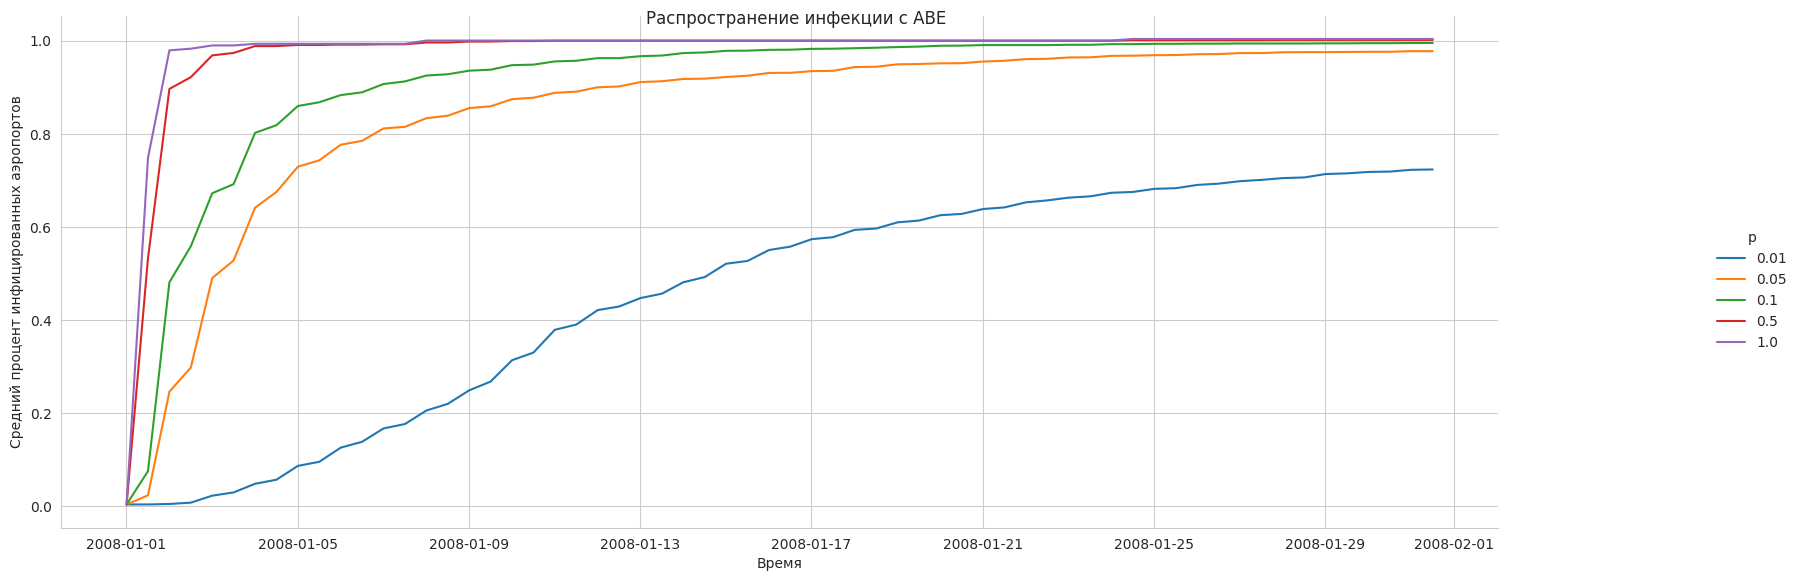

In [93]:
data_viz = pd.DataFrame.from_dict(time_sim_res, orient='index')
data_viz = data_viz.reset_index().melt(id_vars='index', var_name='p')
data_viz['p'] = data_viz.p.astype('category')

sns.set_style('whitegrid')
lp = sns.relplot(data=data_viz, kind='line', x='index', y='value', hue='p')
lp.fig.set_figwidth(20)
lp.fig.set_figheight(6)
lp.fig.suptitle(f'Распространение инфекции с {airport}')
lp.ax.set_xlabel('Время')
lp.ax.set_ylabel('Средний процент инфицированных аэропортов')
plt.show()

# Может ли информация о сети помочь предсказать, кто будет заражен?

In [94]:
@np.vectorize
def get_edge(origin, dest):
    """
    Функция для создания рёбер графа
    """
    if origin < dest:
        result = f'{origin} {dest}'
    else:
        result = f'{dest} {origin}'
    return result

In [95]:
# Число рейсов
nf = data.shape[0]

# Создаём список рёбер из датафрейма
data['edge'] = get_edge(data.Origin, data.Dest)
edgelist = data.groupby('edge').size()/nf
edgelist = edgelist.reset_index()
edgelist[['node1', 'node2']] = edgelist['edge'].str.split(' ', 1, expand=True)
edgelist = edgelist[['node1', 'node2', 0]]
edgelist.columns = ['node1', 'node2', 'weight']
edgelist.to_csv('edgelist.csv', header=False, index=False, sep=' ')
edgelist

node1 node2    weight
0      ABE   ATL  0.000256
1      ABE   CLE  0.000249
2      ABE   CLT  0.000102
3      ABE   CVG  0.000088
4      ABE   DTW  0.000281
...    ...   ...       ...
2381   SRQ   STL  0.000051
2382   STL   TPA  0.000301
2383   STL   TUL  0.000193
2384   SUN   TWF  0.000002
2385   SWF   TPA  0.000076

[2386 rows x 3 columns]

Создадим граф

In [96]:
graph = nx.read_weighted_edgelist('edgelist.csv', nodetype=str)
print(graph.number_of_nodes(), 'nodes and ', graph.number_of_edges(), 'edges in the graph')

287 nodes and  2386 edges in the graph


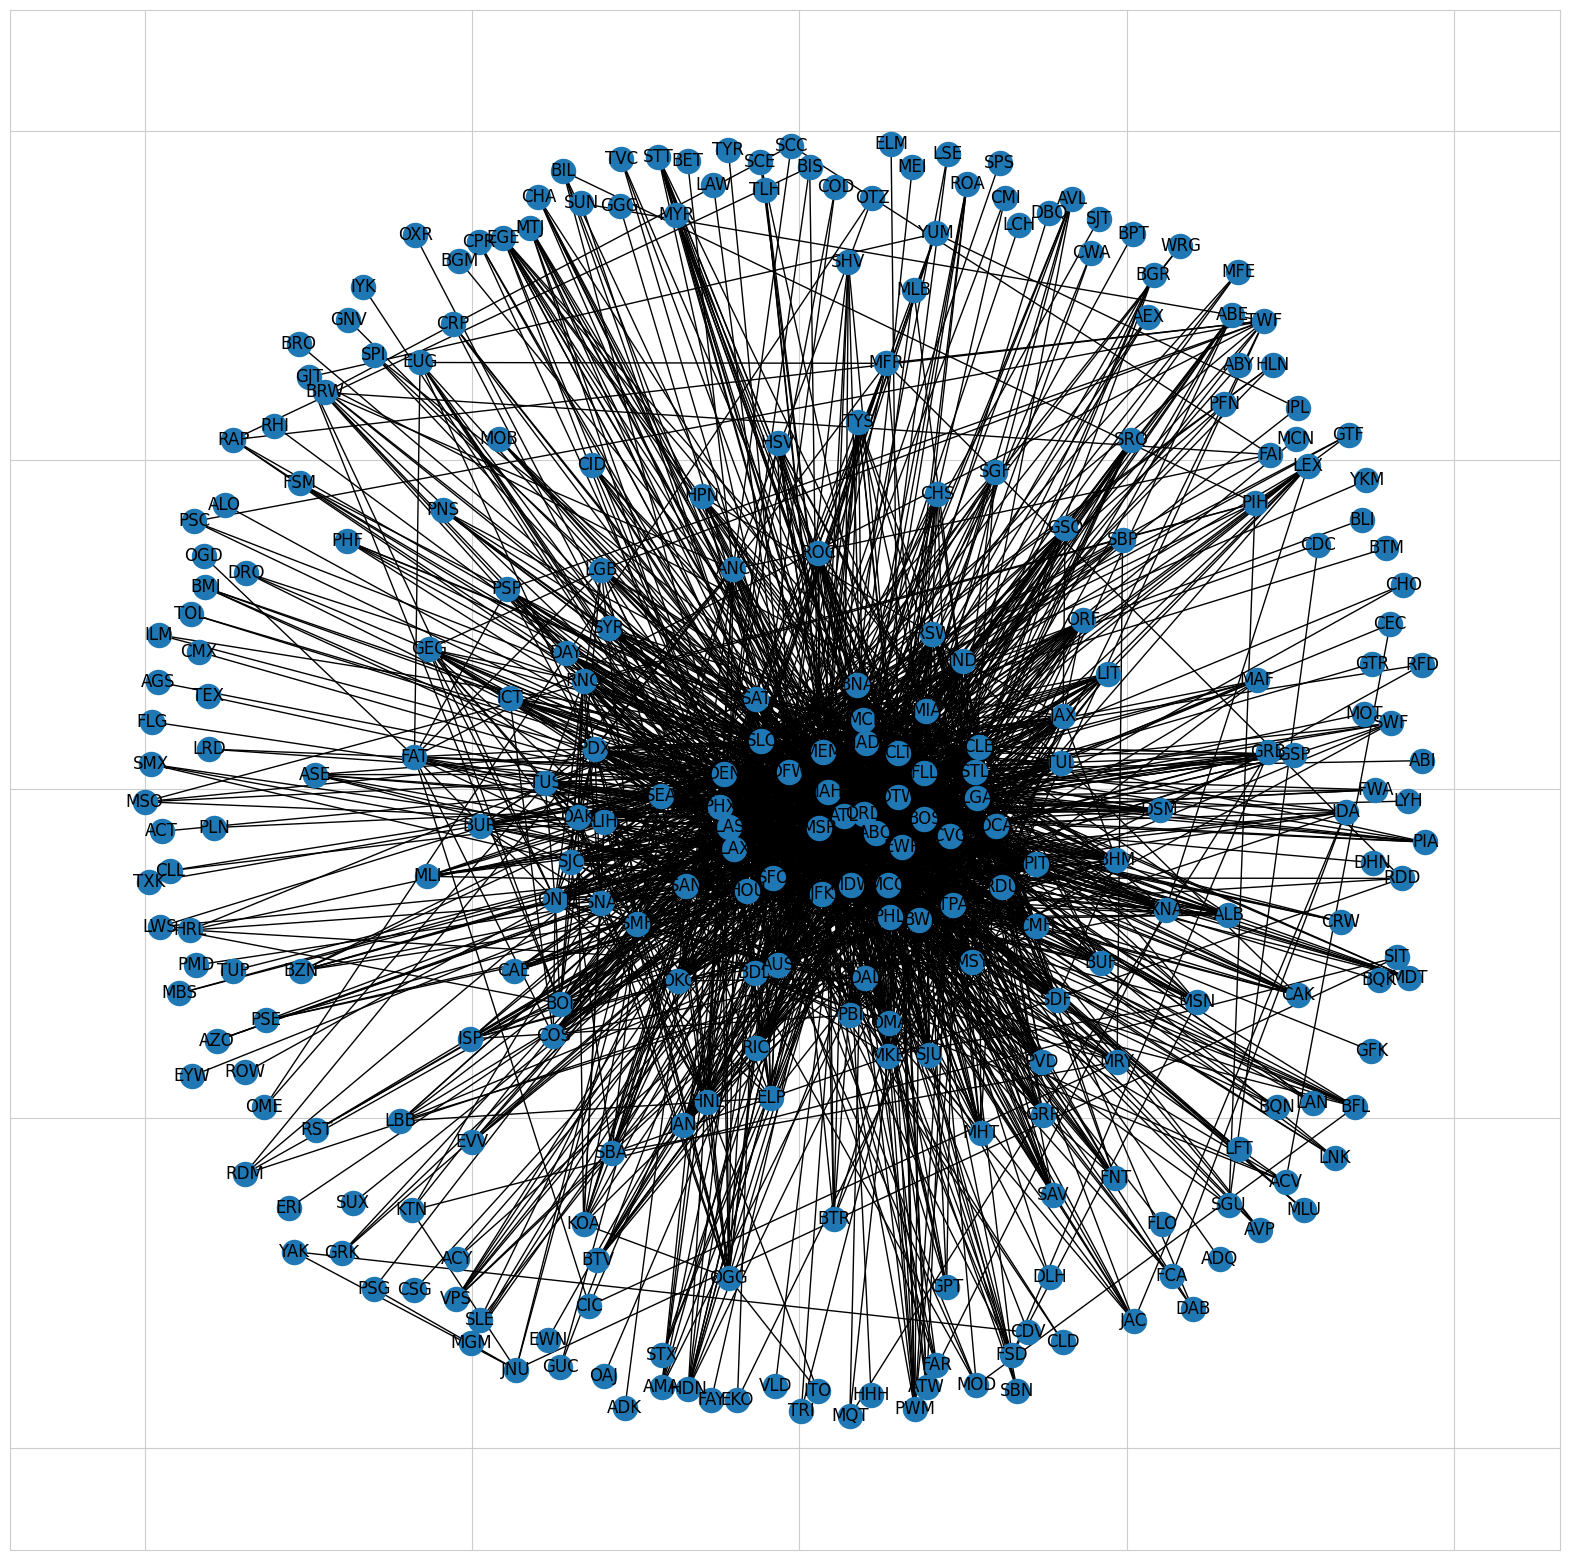

In [97]:
fig = plt.figure(1, figsize=(20, 20))
nx.draw_networkx(graph)

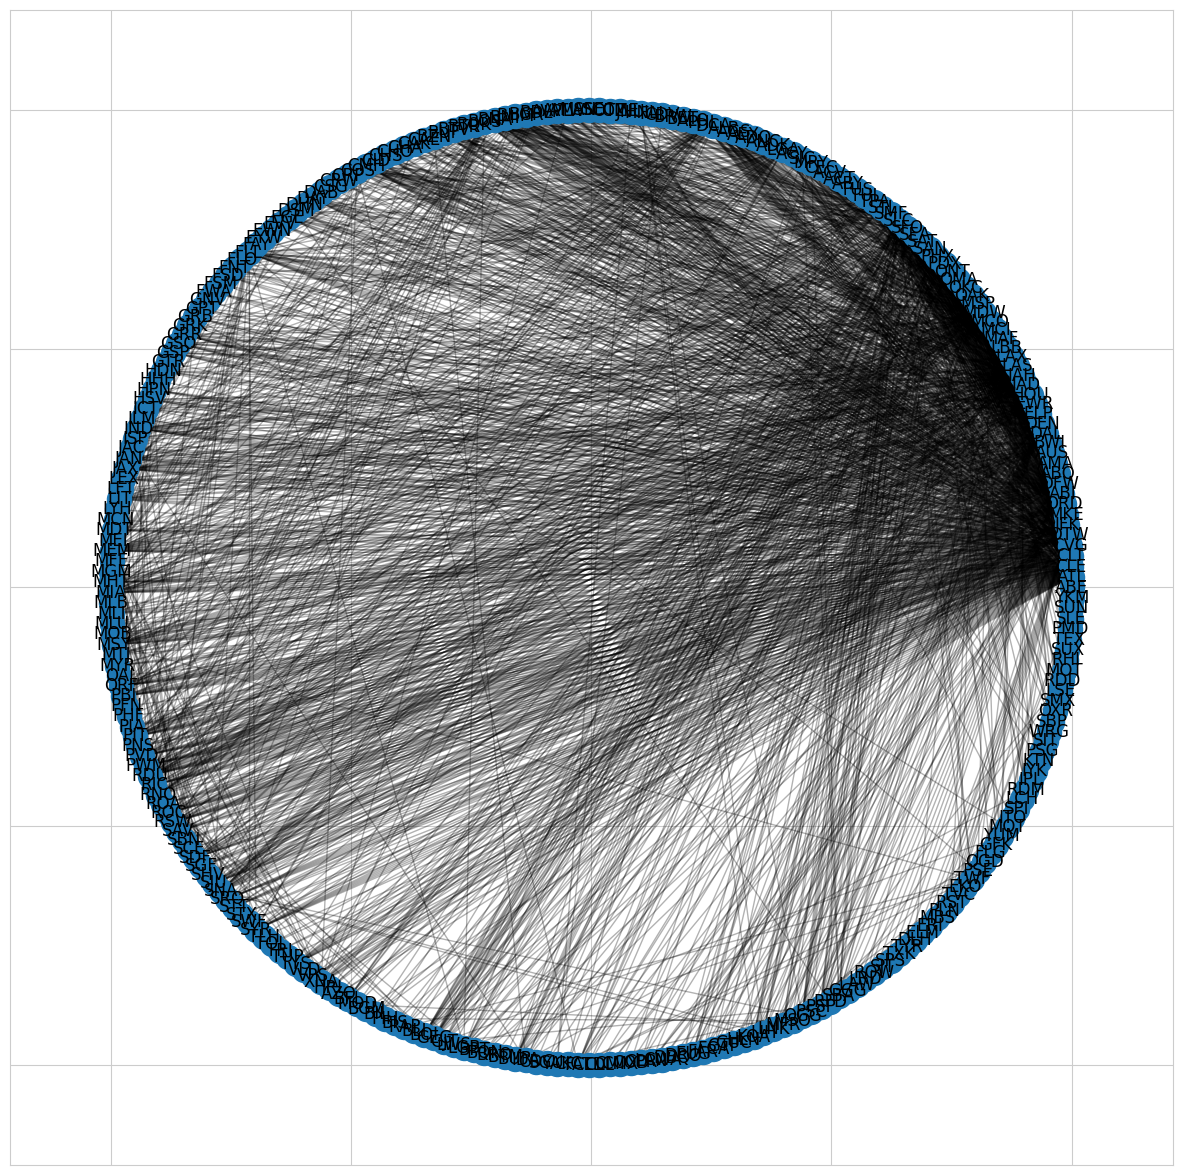

In [98]:
fig = plt.figure(1, figsize=(15, 15))
pos = nx.circular_layout(graph)
nx.draw_networkx_nodes(graph,pos=pos)
nx.draw_networkx_edges(graph,pos=pos,alpha=0.3)
nx.draw_networkx_labels(graph, pos=pos)
plt.show()

Для каждого города посчитаем его коэффициент кластеризации (nx.clustering), степень (nx.degree) и центральность (nx.betweenness_centrality)

In [102]:
clustering = nx.clustering(graph, weight='weight')
degree = dict(graph.degree(weight='weight'))
centrality = nx.betweenness_centrality(graph, weight='weight')

In [103]:
# Соберём все метрики в DataFrame
node_metrics = pd.DataFrame.from_dict(clustering ,orient='index', columns=['clustering']).join([
    pd.DataFrame.from_dict(degree ,orient='index', columns=['degree']),
    pd.DataFrame.from_dict(centrality ,orient='index', columns=['centrality'])
])
node_metrics.head()

clustering    degree  centrality
ABE    0.049903  0.001369    0.029948
ATL    0.020622  0.111910    0.294541
CLE    0.038499  0.017384    0.046392
CLT    0.050012  0.035487    0.090677
CVG    0.025034  0.028621    0.064974

In [107]:
node_metrics.describe()

clustering      degree  centrality
count  287.000000  287.000000  287.000000
mean     0.053468    0.006969    0.021629
std      0.040641    0.014471    0.053136
min      0.000000    0.000002    0.000000
25%      0.019501    0.000490    0.000000
50%      0.055466    0.001328    0.000000
75%      0.077552    0.004990    0.011900
max      0.237713    0.111910    0.406803

# Прогоним симуляцию 50 раз, используя p=0.5 и стартовый аэропорт Allentown

In [99]:
np.random.seed(42)
results_50 = run_simulations('ABE', [0.5], 50)
results_50.to_pickle('sim50res.pkl')

Simulation for p = 0.5


  0%|          | 0/50 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [101]:
results_50 = results_50.reset_index(drop=True)

# Время старта
start_time = results_50.loc[0, 'infected']
print(start_time)

# Подсчёт времени до инфецирования
results_50['dt'] = results_50['infected'] - start_time

# Подсчёт среднего времени
median_time = results_50.groupby('airport')['dt'].median()
assert median_time.isna().sum() == 0

2008-01-01 00:00:00


In [108]:
# Объединим медианное время с node metrics
ap_metrics = node_metrics.join(median_time)

# Конвертируем timedelta в часы
ap_metrics['hours'] = ap_metrics['dt'].dt.seconds/60/60
ap_metrics.head()

clustering    degree  centrality              dt      hours
ABE    0.049903  0.001369    0.029948 0 days 00:00:00   0.000000
ATL    0.020622  0.111910    0.294541 0 days 10:11:00  10.183333
CLE    0.038499  0.017384    0.046392 0 days 10:20:00  10.333333
CLT    0.050012  0.035487    0.090677 0 days 10:22:00  10.366667
CVG    0.025034  0.028621    0.064974 0 days 10:00:00  10.000000

# Визуализация и интерпретация результатов

Построим scatter-plot-ы для медианного времени заражения и каждой из рассчитанных выше метрик. Также посчитаем коэффициент корреляции Спирмана между этими показателями и попробуем проинтерпретировать полученные результаты

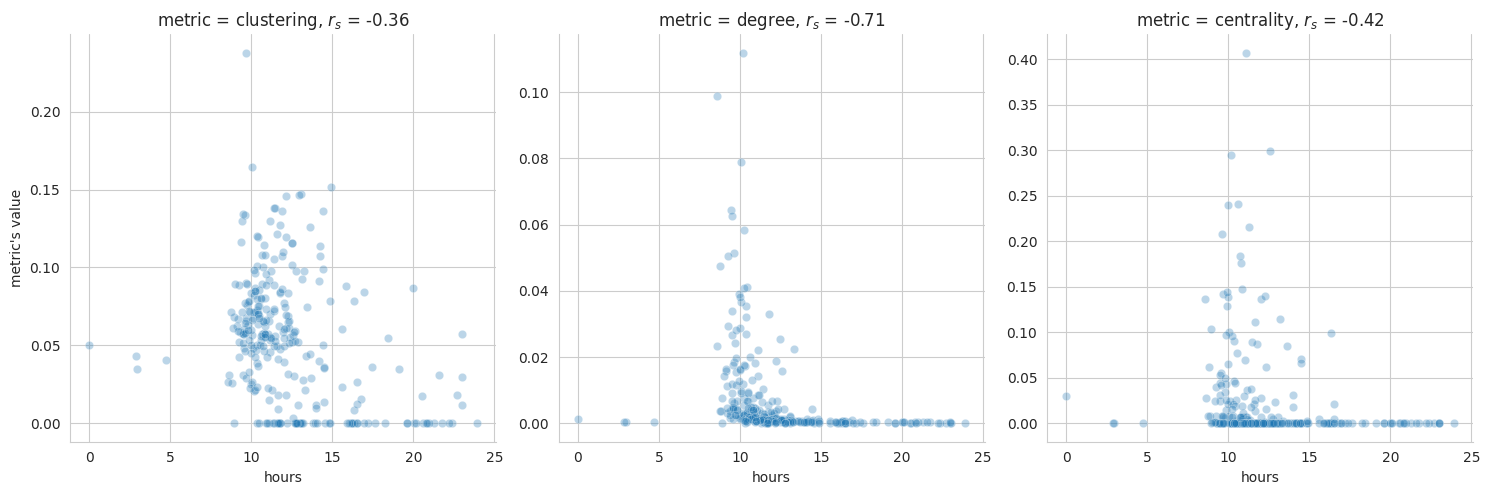

In [113]:
# Вычисление корреляции Спирмана
scorr = ap_metrics.drop('dt', axis=1).corr('spearman').loc['hours']

# Создание датафрейма для визуализации
visual_df = ap_metrics.drop('dt', axis=1).reset_index().melt(id_vars=['index', 'hours'], var_name='metric')

# Визуализация
sp = sns.relplot(data=visual_df, x='hours', y='value', col='metric', facet_kws={'sharey': False, 'sharex': True}, alpha=0.3)
sp.set_ylabels("metric's value")

axes = sp.fig.axes
for ax in axes:
    current_title = ax.get_title()
    metric_name = current_title.split(' ')[2]
    title = f'{current_title}, $r_{{s}}$ = {round(scorr[metric_name], 2)}'
    ax.set_title(title)
plt.show()

На плотерах мы видим слабую отрицательную корреляцию